# CNN Fruit Classifier VS Multiclass SVM

## CNN

In [26]:
import keras
from keras.preprocessing.image import ImageDataGenerator
import h5py
import numpy as np

num_classes = 24
img_rows, img_cols = 100, 100
batch_size = 16

import warnings
warnings.filterwarnings('ignore')

In [27]:
cnn_validation_data_dir = 'frutis_360/fruits-360-original-size/fruits-360-original-size/Validation'

In [28]:
cnn_validation_datagen = ImageDataGenerator(rescale=1./255)

print("Validation: ")
validation_generator = cnn_validation_datagen.flow_from_directory(
        cnn_validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size =batch_size,
        class_mode='categorical',
        shuffle=True)

Validation: 
Found 3114 images belonging to 24 classes.


In [29]:
model = keras.models.load_model('fruits_fresh_cnn_1.h5')

In [30]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 activation (Activation)     (None, 100, 100, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 98, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 98, 98, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 49, 49, 32)        0         
                                                        

In [31]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

In [32]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

2024-01-20 19:20:36.602110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Confusion Matrix
[[ 3 10 12 10 16  9  9 11  6 10 11  6  6  5  4  0  0  2  6  3  4  7  4  4]
 [ 8 10  8 10  7 13 11 13  4  8  5  6  4  5 11  1  2  2  7  3  9  4  5  4]
 [10  9  6  6  7  5  9 16 11  6 11 10  5 11  7  0  2  1  2  3  8  3  6  5]
 [11 10  5  3  6  6  9 10 13  7 12 15  8  7  5  0  1  3  4  4  5  6  3  1]
 [12  6 11  3  4  8  6  8  7  5  8  6 10 13 10  2  2  4  6  4  5  2  4  8]
 [ 5  7 13  9  4  5  6 10  6  7  8  6 11 11 11  0  2  2  4  2 10  3 12  4]
 [ 4 11  9 14  5  9  7 17  6  7  6  9  6  6 10  1  3  2  6  2  9  2  4  5]
 [10 15 15 11  9  9 10 22 13 11 11  9 11 10 12  1  5  3 10  6 10  4 11  6]
 [11  6  6  9  8  6  9 14  4  9  7  9  3 10  6  1  3  2  1  3 14  6  5  4]
 [10  7  5  6 10  9 11  8  7  8  7  5 12  3  4  1  4  6  6  6 13  1  3  3]
 [ 6  7  7 12  8  8 11 10  8 13  8  6  9  5  6  2  2  3  3  2  9  5  4  5]
 [ 8  6  2  9 11  3  7 10 10  5  5 11 10  5  3  5  3  2  4  5  7  3  4  3]
 [12  6  5  5  7  5  7 13 10 11  5  5 10  6  9  3  2  2  3  4  4  3  8  5]
 [12  5 

2024-01-20 19:15:07.687119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


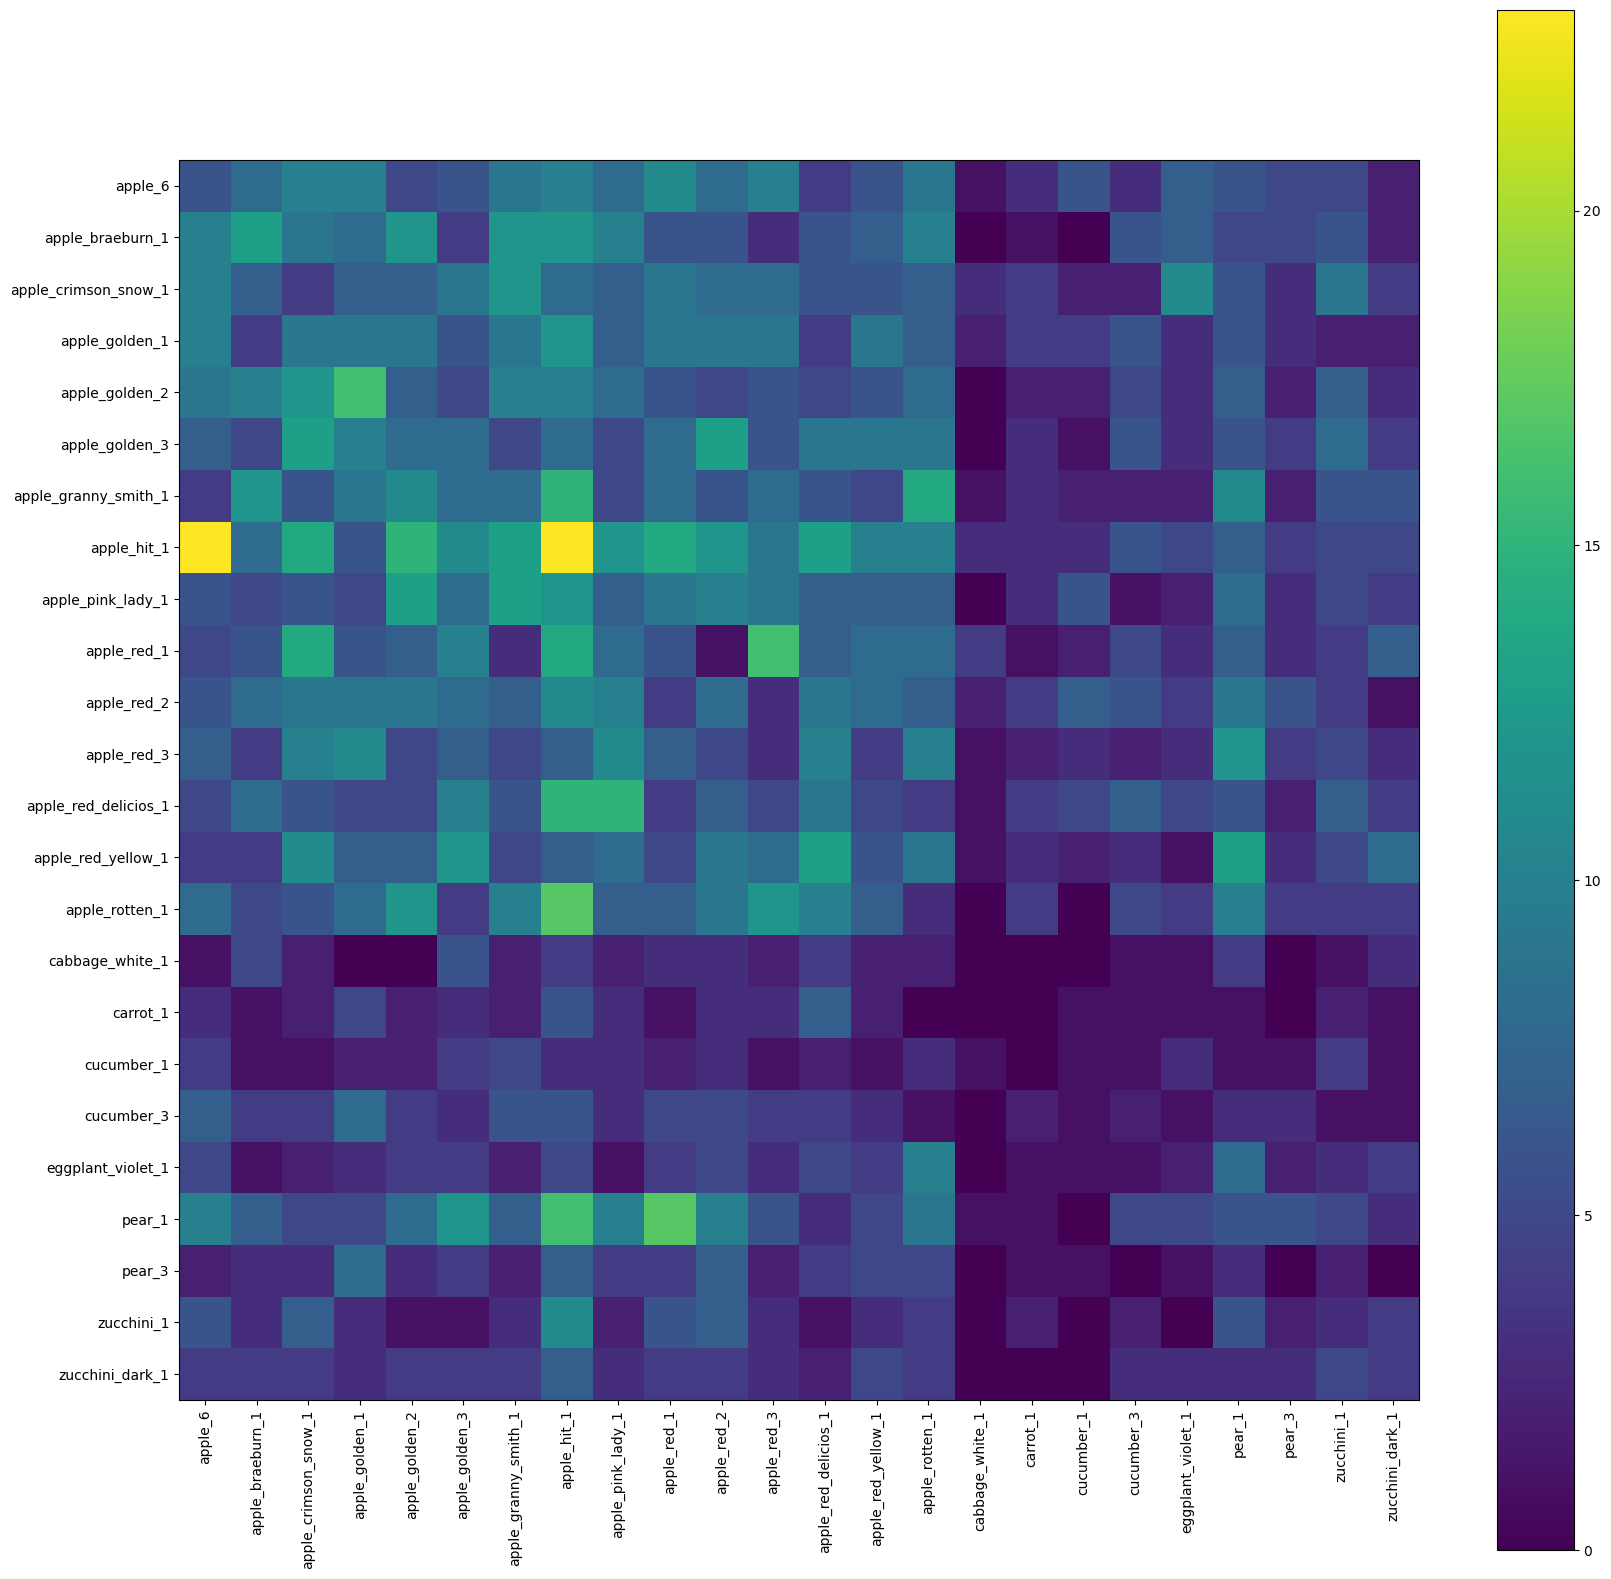

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import load_model

nb_validation_samples = 3114


#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(class_labels.values())

plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

---

## SVM anwenden

In [18]:
from joblib import load
import glob
import os
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [19]:
def getAllData(data_type, dim, print_summary=False):
    images = []
    labels = []

    # Basispfad für das Verzeichnis der Daten
    base_path = "frutis_360/fruits-360-original-size/fruits-360-original-size/"

    # Funktion, um alle Unterordner (Datenkategorien) zu erhalten
    def get_categories(path):
        return [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

    categories = get_categories(os.path.join(base_path, data_type))
    total_images = 0  # Gesamtzahl der Bilder zählen

    for i, category in enumerate(categories):
        category_path = os.path.join(base_path, data_type, category)
        for image_path in glob.glob(os.path.join(category_path, "*.jpg")):
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (dim, dim))
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            images.append(image)
            labels.append(i)
            total_images += 1

    if print_summary:
        print(f"Found {total_images} images belonging to {len(categories)} classes.")

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [20]:
# Setzen Sie die Bildgröße fest
dim = 100

print("Validation: ")
X_test, y_test = getAllData('Validation', dim, print_summary=True)

Validation: 
Found 3114 images belonging to 24 classes.


In [21]:
#Scale Data Images
scaler = StandardScaler()
X_test = scaler.fit_transform([i.flatten() for i in X_test])

In [22]:
# Ersetzen Sie 'svm_model.joblib' mit dem Pfad zu Ihrer .joblib-Datei
svm_model = load('svm_multi_classifier.joblib')

In [23]:
svm_predictions = svm_model.predict(X_test)

In [24]:
test_accuracy = accuracy_score(y_test, svm_predictions)
print("Testgenauigkeit:", test_accuracy)

Testgenauigkeit: 1.0


In [25]:
print("Classification Report:\n", classification_report(y_test, svm_predictions))
poly_accuracy = accuracy_score(y_test, svm_predictions)
poly_f1 = f1_score(y_test, svm_predictions, average='weighted')
print('Accuracy (Polynomial Kernel): {:.2f}%'.format(poly_accuracy*100))
print('F1 (Polynomial Kernel): {:.2f}'.format(poly_f1*100))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        81
           1       1.00      1.00      1.00        80
           2       1.00      1.00      1.00        80
           3       1.00      1.00      1.00       154
           4       1.00      1.00      1.00       159
           5       1.00      1.00      1.00       162
           6       1.00      1.00      1.00       150
           7       1.00      1.00      1.00       160
           8       1.00      1.00      1.00       158
           9       1.00      1.00      1.00       154
          10       1.00      1.00      1.00       155
          11       1.00      1.00      1.00        50
          12       1.00      1.00      1.00       160
          13       1.00      1.00      1.00       160
          14       1.00      1.00      1.00        48
          15       1.00      1.00      1.00        50
          16       1.00      1.00      1.00        71
   